# Saliencies for CondVAE model

Compute saliencies to understand what channels the model is focussing on for a specific latent space.

Procedure:
- Calculate integrated gradients [(Sundararajan, 2017)](https://arxiv.org/abs/1703.01365) for `aggregated/sub-0.001` dataset of `CondVAE_pert-CC`
- Calculate mean gradients per cluster and channel using annotated "clustering_res0.5"
- Z-score mean gradients per cluster to get an indication which channels are important for which cluster
- Those channels that don't have a high z-score in any cluster are channels the model is not focussing on and might be variable channels

TODO: Suppl Figure with z-scored mean_ig per cluster and channel. List all channels the model does not focus on in figure caption.

In [2]:
from campa.constants import campa_config
from campa.tl import Experiment, Predictor, Cluster
from campa_ana.constants import SOURCE_DIR
from campa.data import MPPData
import os
from campa.tl._cluster import annotate_clustering
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

fig_dir = Path(SOURCE_DIR)/'figures'/'fig1_suppl'
os.makedirs(str(fig_dir), exist_ok=True)

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


## Integrated gradients function
Code adapted from here: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients


In [3]:
def interpolate_mpps(baseline,mpp,alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(mpp, axis=0)
    delta = input_x - baseline_x
    mpps = baseline_x +  alphas_x * delta
    return mpps

def compute_gradients(pred, mpps, condition):
    with tf.GradientTape() as tape:
        tape.watch(mpps)
        logits = pred.est.model.encoder((mpps, tf.tile(condition, [len(mpps),1])))
    return tape.gradient(logits, mpps)

def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

def integrated_gradients(pred, mpp, condition, m_steps=50):
    baseline = tf.zeros_like(mpp)
    # Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # Get Gradients
    interpolated_mpps = interpolate_mpps(baseline, mpp, alphas)
    gradients = compute_gradients(pred, interpolated_mpps, condition)
    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (mpp - baseline) * avg_gradients

    return integrated_gradients

## Load data

In [4]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
pred = Predictor(exp)
mpp_data = MPPData.from_data_dir('aggregated/sub-0.001', data_config='NascentRNA', base_dir=exp.full_path, keys=['latent', 'conditions', 'clustering_res0.5'])
cluster_annotation = pd.read_csv(os.path.join(exp.full_path, 'aggregated/sub-0.001/clustering_res0.5_annotation.csv'), index_col=0)
# add annotation of clustering to mpp_data
mpp_data._data['annotation'] = annotate_clustering(list(map(int, mpp_data.data('clustering_res0.5'))), annotation=cluster_annotation, cluster_name='clustering_res0.5', annotation_col='annotation')

2022-11-02 14:53:21.655581: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Calculate gradients

In [5]:
# calculate gradients for all samples
grads = []
for i in range(len(mpp_data.mpp)):
    mpp = tf.convert_to_tensor(mpp_data.mpp[i])
    cond = tf.expand_dims(tf.convert_to_tensor(mpp_data.conditions[i]), axis=0)
    grads.append(integrated_gradients(pred, mpp, cond).numpy())
grads = np.array(grads)
annotation = np.array(mpp_data._data['annotation'])
    

## Plot results

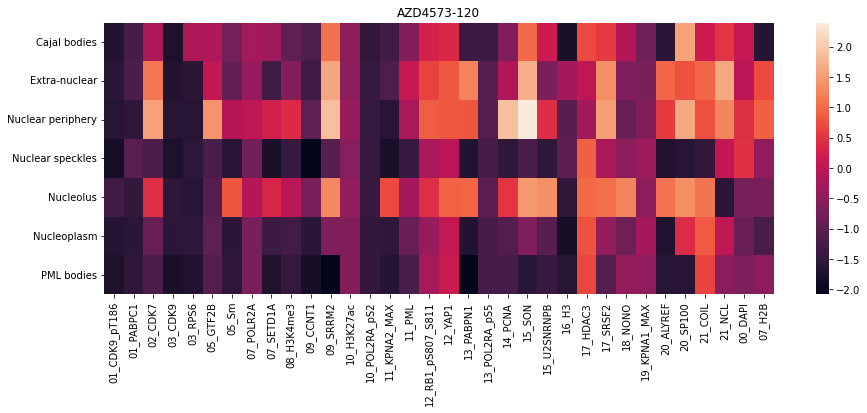

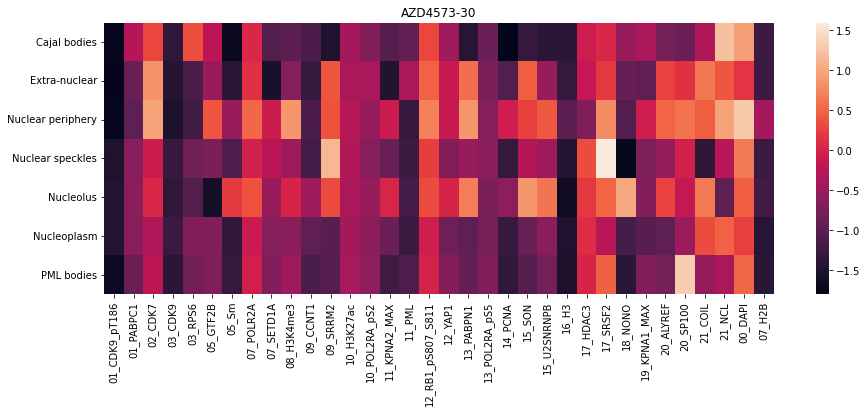

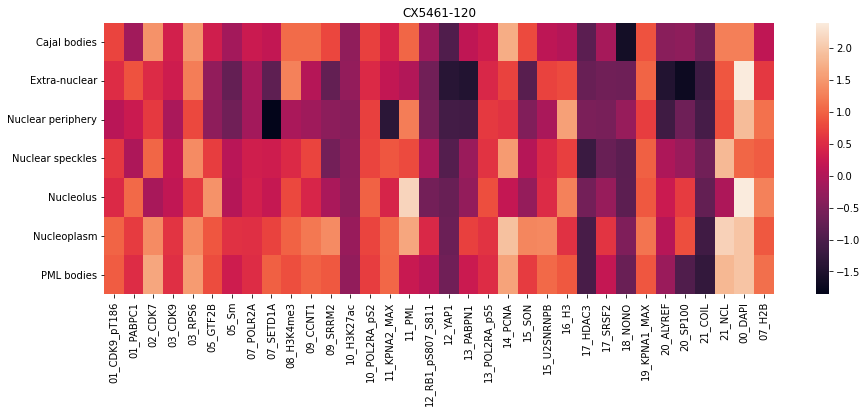

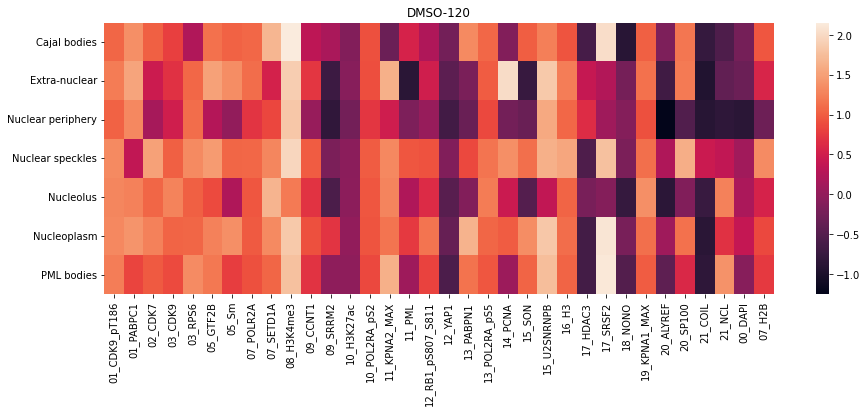

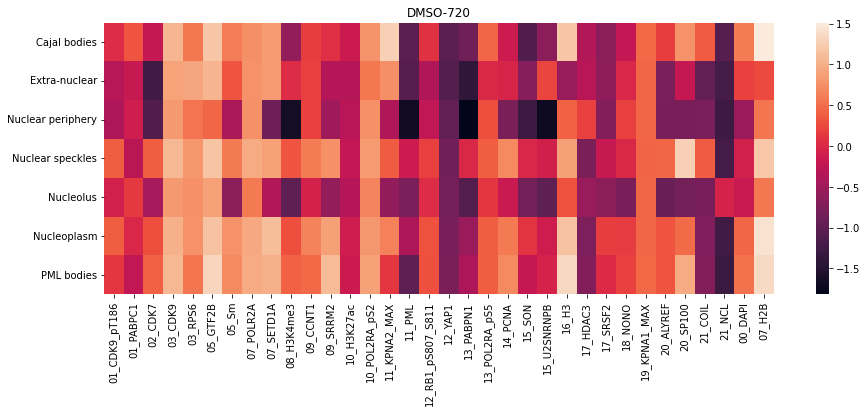

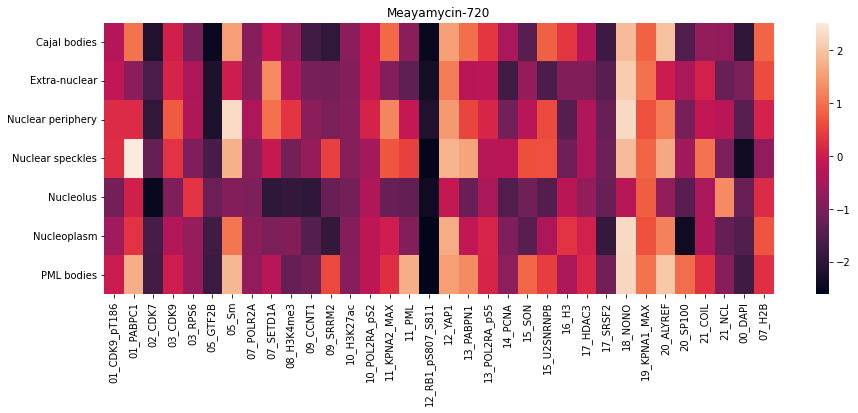

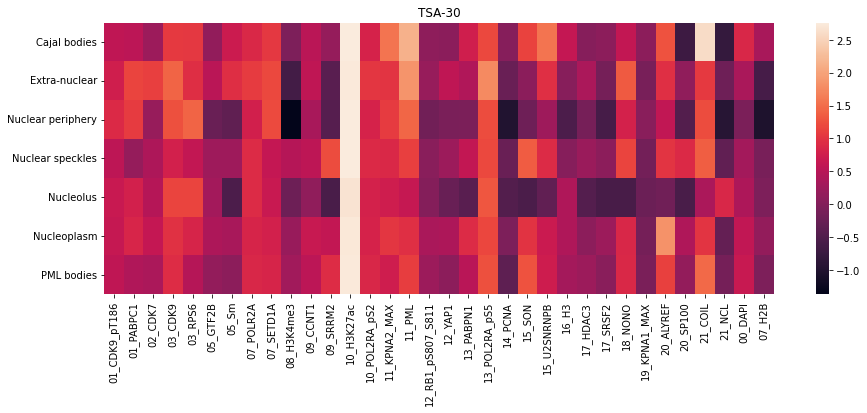

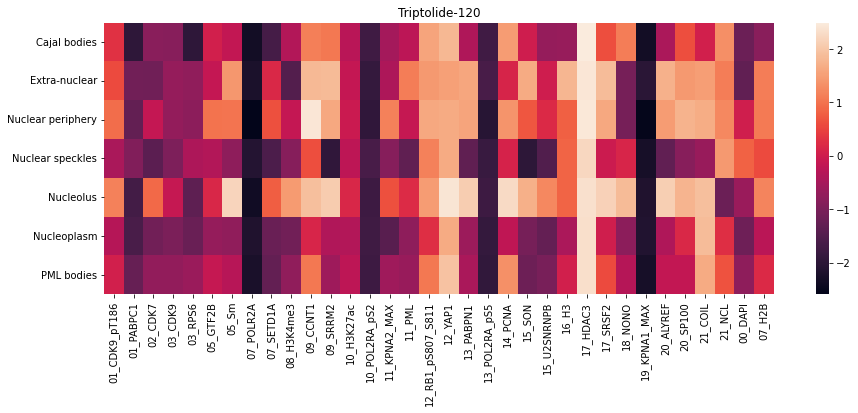

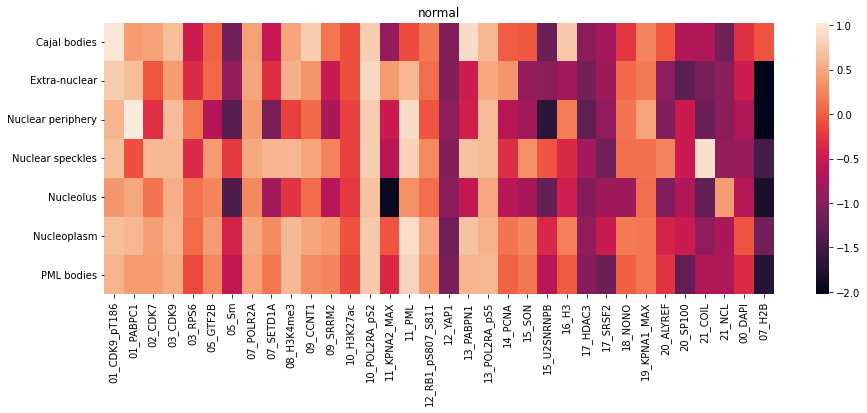

In [214]:
# IG per perturbation

perturbations = ['AZD4573-120', 'AZD4573-30', 'CX5461-120', 'DMSO-120', 'DMSO-720',
       'Meayamycin-720', 'TSA-30', 'Triptolide-120', 'normal']
clusters = np.unique(annotation)
channels = list(mpp_data.channels.name)

mean_ig = np.zeros((len(perturbations), len(clusters), len(channels)))
# calculate mean ig for each pert,cl,ch
for k,pert in enumerate(perturbations):
    obj_mask = mpp_data.metadata['perturbation_duration'] == pert
    mpp_mask = mpp_data._get_per_mpp_value(obj_mask)
    for i,cl in enumerate(clusters):
       mask = annotation == cl
       for j, ch in enumerate(channels):
              mean_ig[k,i,j] = np.abs(grads[mask & mpp_mask][:,:,:,j]).mean()
# calculate z-scored mean_ig
mean_ig = (mean_ig - mean_ig.mean(axis=0, keepdims=True)) / mean_ig.std(axis=0, keepdims=True)

# plot mean_ig per perturbation
for k,pert in enumerate(perturbations):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.set_title(pert)
    #sns.clustermap(mean_ig[k], cmap="vlag", figsize=[14,9], method='ward', yticklabels=clusters, xticklabels=channels)
    sns.heatmap(mean_ig[k], yticklabels=clusters, xticklabels=channels, ax=ax)

In [11]:
# IG for all
clusters = np.unique(annotation)
channels = list(mpp_data.channels.name)
mean_ig = np.zeros((len(clusters), len(channels)))
std_ig = np.zeros((len(clusters), len(channels)))

for i,cl in enumerate(clusters):
    mask = annotation == cl
    for j, ch in enumerate(channels):
        mean_ig[i,j] = np.abs(grads[mask][:,:,:,j]).mean()
        std_ig[i,j] = np.abs(grads[mask][:,:,:,j]).std()

# calculate z-scored mean_ig
mean_ig = (mean_ig - mean_ig.mean(axis=0, keepdims=True)) / mean_ig.std(axis=0, keepdims=True)

any markers for cluster ['Cajal bodies' 'Extra-nuclear' 'Nuclear periphery' 'Nuclear speckles'
 'Nucleolus' 'Nucleoplasm' 'PML bodies'] [ True False  True  True  True False  True]
any markers for channel ['01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9', '03_RPS6', '05_GTF2B', '05_Sm', '07_POLR2A', '07_SETD1A', '08_H3K4me3', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2', '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1', '13_POL2RA_pS5', '14_PCNA', '15_SON', '15_U2SNRNPB', '16_H3', '17_HDAC3', '17_SRSF2', '18_NONO', '19_KPNA1_MAX', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '00_DAPI', '07_H2B'] [False False False False False False False False False False False  True
 False False False  True False False False False False  True False  True
 False  True False False False  True  True  True False  True]


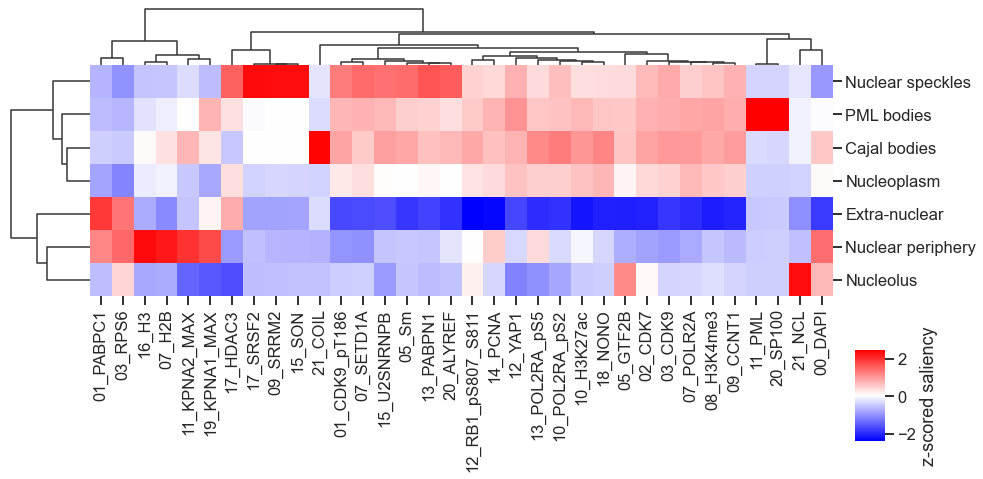

In [12]:
sns.set_context("talk")
sns.set_style("ticks")
g = sns.clustermap(mean_ig, cmap="bwr", figsize=[14,7], method='ward', yticklabels=clusters, xticklabels=channels, cbar_kws={'label': 'z-scored saliency'}, tree_kws={'linewidths':1.5}, cbar_pos=(0.86,0.1,0.03,0.18), dendrogram_ratio=(0.1,0.2))
plt.savefig(fig_dir / 'saliency_zscored.png', dpi=300)
#g.fig.suptitle('Saliency (z-scored, row-normalised)')

print('any markers for cluster', clusters, (mean_ig > 2).any(axis=1))
print('any markers for channel', channels, (mean_ig > 2).any(axis=0))

In [13]:
# IG for only normal
obj_mask = mpp_data.metadata['perturbation_duration'] == 'normal'
mpp_mask = mpp_data._get_per_mpp_value(obj_mask)

clusters = np.unique(annotation)
channels = list(mpp_data.channels.name)
mean_ig = np.zeros((len(clusters), len(channels)))
std_ig = np.zeros((len(clusters), len(channels)))

for i,cl in enumerate(clusters):
    mask = annotation == cl
    for j, ch in enumerate(channels):
        mean_ig[i,j] = np.abs(grads[mask & mpp_mask][:,:,:,j]).mean()
        std_ig[i,j] = np.abs(grads[mask & mpp_mask][:,:,:,j]).std()

# calculate z-scored mean_ig
mean_ig = (mean_ig - mean_ig.mean(axis=0, keepdims=True)) / mean_ig.std(axis=0, keepdims=True)

any markers for cluster ['Cajal bodies' 'Extra-nuclear' 'Nuclear periphery' 'Nuclear speckles'
 'Nucleolus' 'Nucleoplasm' 'PML bodies'] [ True False  True  True  True False  True]
any markers for channel ['01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9', '03_RPS6', '05_GTF2B', '05_Sm', '07_POLR2A', '07_SETD1A', '08_H3K4me3', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2', '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1', '13_POL2RA_pS5', '14_PCNA', '15_SON', '15_U2SNRNPB', '16_H3', '17_HDAC3', '17_SRSF2', '18_NONO', '19_KPNA1_MAX', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '00_DAPI', '07_H2B'] [False False False False False False False False False False False  True
 False False False  True False False False False False  True False  True
 False  True False False False  True  True  True False  True]


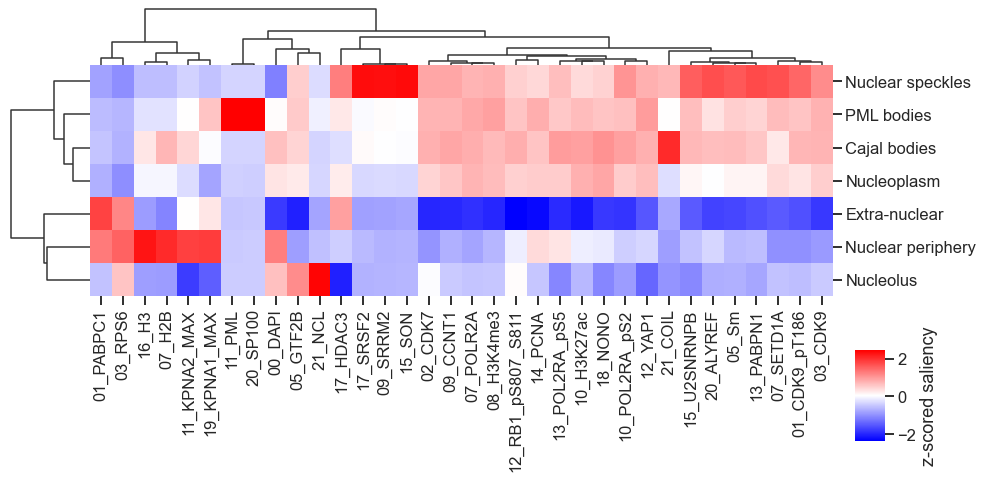

In [14]:
sns.set_context("talk")
sns.set_style("ticks")
g = sns.clustermap(mean_ig, cmap="bwr", figsize=[14,7], method='ward', yticklabels=clusters, xticklabels=channels, cbar_kws={'label': 'z-scored saliency'}, tree_kws={'linewidths':1.5}, cbar_pos=(0.86,0.1,0.03,0.18), dendrogram_ratio=(0.1,0.2))
#plt.savefig(fig_dir / 'saliency_zscored.png', dpi=300)
#g.fig.suptitle('Saliency (z-scored, row-normalised)')

print('any markers for cluster', clusters, (mean_ig > 2).any(axis=1))
print('any markers for channel', channels, (mean_ig > 2).any(axis=0))

In [17]:
# print channels that don't contribute to any clustering (when considering gradients). Are these the condition-dependent channels?
print(np.array(channels)[~(mean_ig > 2).any(axis=0)])
print(np.array(channels)[(mean_ig > 2).any(axis=0)])

['01_CDK9_pT186' '01_PABPC1' '02_CDK7' '03_CDK9' '03_RPS6' '05_GTF2B'
 '05_Sm' '07_POLR2A' '07_SETD1A' '08_H3K4me3' '09_CCNT1' '10_H3K27ac'
 '10_POL2RA_pS2' '11_KPNA2_MAX' '12_RB1_pS807_S811' '12_YAP1' '13_PABPN1'
 '13_POL2RA_pS5' '14_PCNA' '15_U2SNRNPB' '17_HDAC3' '18_NONO'
 '19_KPNA1_MAX' '20_ALYREF' '00_DAPI']
['09_SRRM2' '11_PML' '15_SON' '16_H3' '17_SRSF2' '20_SP100' '21_COIL'
 '21_NCL' '07_H2B']


In [7]:
mpp_data.mpp[:,1,1,:].mean(axis=0)

array([0.22113357, 0.28462243, 0.35623616, 0.24378474, 0.4080675 ,
       0.44084996, 0.39808372, 0.28783432, 0.24391493, 0.3621032 ,
       0.31551614, 0.15995875, 0.22765149, 0.36883298, 0.3546832 ,
       0.12505227, 0.38114935, 0.44220597, 0.4146705 , 0.42851868,
       0.3595155 , 0.15609328, 0.4024017 , 0.47103328, 0.44831493,
       0.16283594, 0.45744365, 0.4729707 , 0.43403357, 0.08563764,
       0.33451077, 0.23359577, 0.47415808, 0.5426458 ], dtype=float32)

In [19]:
# plot gradients not in dependence with clustering
np.abs(grads[mpp_mask][:,1,1,:]).mean(axis=0) / mpp_data.mpp[mpp_mask][:,1,1,:].mean(axis=0)

array([0.07833079, 0.11642526, 0.04393647, 0.08050817, 0.27165556,
       0.18327196, 0.17384161, 0.08612849, 0.1532469 , 0.03953305,
       0.05192215, 0.29582477, 0.06634346, 0.17243053, 0.1601725 ,
       0.1317211 , 0.61074805, 0.09655283, 0.1899093 , 0.11197903,
       0.07757736, 0.28207958, 0.1848171 , 0.15211847, 0.00348281,
       0.1926343 , 0.02850558, 0.01658944, 0.11633079, 0.13969891,
       0.00425823, 0.5479293 , 0.34481654, 0.15333045], dtype=float32)

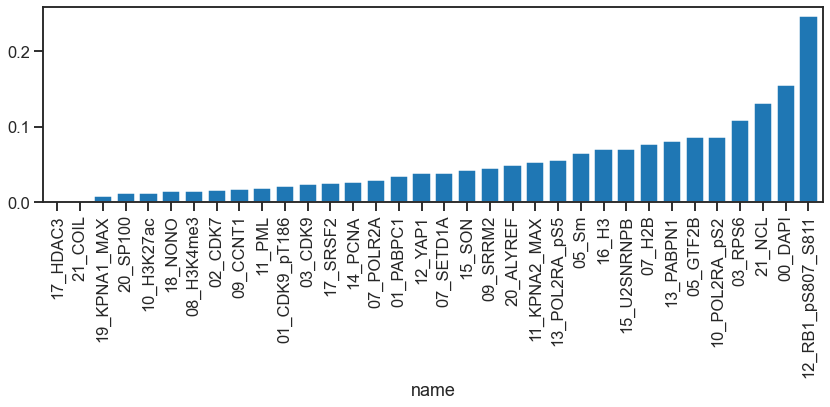

In [23]:
channels = mpp_data.channels.copy()
channels['grads'] = np.abs(grads[mpp_mask][:,1,1,:]).mean(axis=0)

sns.set_context("talk")
sns.set_style("ticks")

fig, ax = plt.subplots(1,1, figsize=(12,6))
channels.set_index('name').sort_values('grads').plot(kind='bar', ax=ax, legend=None, width=0.8)
plt.tight_layout()
#plt.savefig(fig_dir / 'saliency_condition_gradxinput.png', dpi=300)

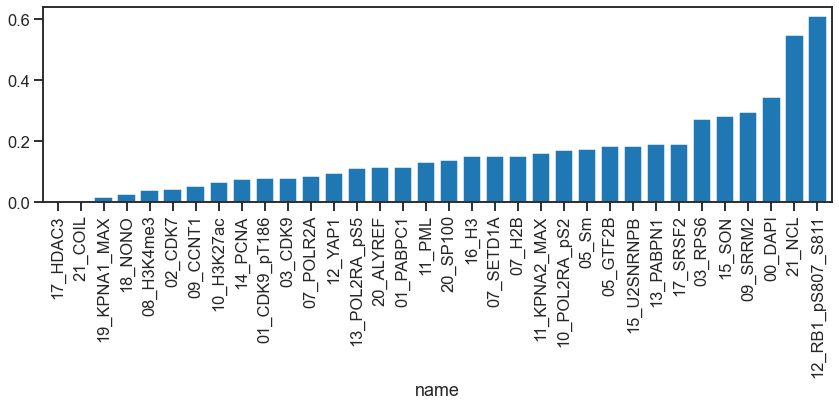

In [22]:
channels = mpp_data.channels.copy()
channels['grads'] = np.abs(grads[mpp_mask][:,1,1,:]).mean(axis=0) / mpp_data.mpp[mpp_mask][:,1,1,:].mean(axis=0)

sns.set_context("talk")
sns.set_style("ticks")

fig, ax = plt.subplots(1,1, figsize=(12,6))
channels.set_index('name').sort_values('grads').plot(kind='bar', ax=ax, legend=None, width=0.8)
plt.tight_layout()
#plt.savefig(fig_dir / 'saliency_condition_gradxinput.png', dpi=300)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00, 8.50000e+01,
        6.50200e+03, 3.19241e+05, 1.41050e+04, 6.00000e+01, 2.00000e+00]),
 array([-0.01932704, -0.01638249, -0.01343795, -0.0104934 , -0.00754885,
        -0.00460431, -0.00165976,  0.00128478,  0.00422933,  0.00717387,
         0.01011842], dtype=float32),
 <BarContainer object of 10 artists>)

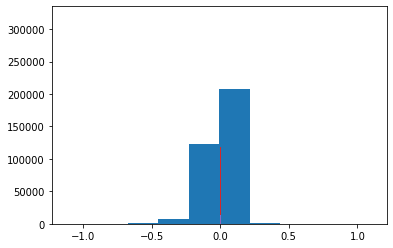

In [131]:
# look at gradients over neighborhood
# gradients over neighborhood are really small compared to center pixel
plt.hist(grads[:,1,1].flat)
plt.hist(grads[:,0,0].flat)
plt.hist(grads[:,2,0].flat)
plt.hist(grads[:,2,2].flat)
plt.hist(grads[:,0,2].flat)